# Identify Customer Segments

In this project, I apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I
use has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here; add more as necessary
from lib.workspace_utils import active_session
import time 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

All of the `.csv` data files in this project: they're semicolon (`;`) delimited, so I need an additional argument in  [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
#checking the unique types of how missing values were encoded
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [8]:
#which columns have strange encodings with 'X' values?
print(feat_info['attribute'][feat_info['missing_or_unknown']=='[-1,X]'])
print(feat_info['attribute'][feat_info['missing_or_unknown']=='[XX]'])
print(feat_info['attribute'][feat_info['missing_or_unknown']=='[-1,XX]'])

57    CAMEO_DEUG_2015
Name: attribute, dtype: object
58    CAMEO_DEU_2015
Name: attribute, dtype: object
59    CAMEO_INTL_2015
Name: attribute, dtype: object


In [9]:
# how many values were encoded with X or XX?
print(azdias[azdias['CAMEO_DEUG_2015'] =='X'].shape)
print(azdias[azdias['CAMEO_DEU_2015'] =='XX'].shape)
print(azdias[azdias['CAMEO_INTL_2015'] =='XX'].shape)

(373, 85)
(373, 85)
(373, 85)


In [10]:
#are these the same rows that miss data for the three columns with 'X' encodings?
print((azdias[azdias['CAMEO_DEUG_2015'] =='X'].index == azdias[azdias['CAMEO_DEU_2015'] =='XX'].index).sum())
print((azdias[azdias['CAMEO_DEU_2015'] =='XX'].index == azdias[azdias['CAMEO_INTL_2015'] =='XX'].index).sum())
print((azdias[azdias['CAMEO_DEUG_2015'] =='X'].index == azdias[azdias['CAMEO_INTL_2015'] =='XX'].index).sum())

373
373
373


Summary: it seems like there are 373 rows that have missing values encoded with either 'X' or 'XX' and all these values come from just three columns 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015' and 'CAMEO_INTL_2015'. 

In [11]:
#NaNs in the original dataset
nans_origin = azdias.isna().sum().sum()
nans_origin

4896838

In [12]:
azdias.duplicated().value_counts()

False    838727
True      52494
dtype: int64

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. 

From initial look at the data, we know that the missing/unknown values were encoded either with digits -1, 0, 9 or with letters 'X' or 'XX'. In the following, I first convert X/XX values to NaNs. Then I convert digits to NaNs.

In [13]:
azdias_clean = azdias.replace({'X': np.nan, 'XX': np.nan})

In [14]:
def transform_missing_in_featinfo(col):
    col = col.apply(lambda x: '[-1]' if x in ['[-1,X]', '[XX]', '[-1,XX]'] else x)
    col = [eval(col[i]) for i in col.index]
    return col

In [15]:
feat_info['missing_transform'] = transform_missing_in_featinfo(feat_info['missing_or_unknown'])

In [16]:
feat_info['missing_transform'].head()

0       [-1, 0]
1    [-1, 0, 9]
2       [-1, 0]
3           [0]
4          [-1]
Name: missing_transform, dtype: object

**Commentary**: we cannot just replace all -1, 0 or 9 values with NaNs. What if they are meaningful in another column? So we need to go through each column and replace values that were encoded as missing specifically for this column:

In [17]:
# Identify missing or unknown data values and convert them to NaNs
for i, col in enumerate(feat_info['attribute']):
    azdias_clean.loc[azdias_clean[col].isin(feat_info['missing_transform'][i]), col] = np.nan

In [18]:
# alternative way:
#finding all digits in a string object '[-1, 0, 9]' and converting it to a list 

#import re
#for i in feat_info['missing_or_unknown'].index:
#    feat_info['missing_or_unknown'][i] = [int(s) for s in re.findall(r'-?\d+', feat_info['missing_or_unknown'][i])]

In [19]:
#number of NaNs after conversion:
azdias_clean.isna().sum().sum()

8373929

**Commentary**: In the original dataset we had 4896838 naturally missing values. After conversion we have now 8373929 NaNs. So, there are 3477091 values that were encoded as 'missing' or 'unknown'. <br>
Is it a lot? Well, given that the original dataset has 891221 x 85 = 75753785 datapoints, the final prop of missing values after conversion is about 11%.

In [20]:
# checking the NaNs in the data frame
col_missing_prop = pd.DataFrame(azdias_clean.isna().mean(axis=0)).reset_index()
col_missing_prop.columns = ['features', 'missing_prop']
col_missing_prop.head(15)

,features,missing_prop
0,AGER_TYP,0.769554
1,ALTERSKATEGORIE_GROB,0.003233
2,ANREDE_KZ,0.000000
3,CJT_GESAMTTYP,0.005446
4,FINANZ_MINIMALIST,0.000000
5,FINANZ_SPARER,0.000000
6,FINANZ_VORSORGER,0.000000
7,FINANZ_ANLEGER,0.000000
8,FINANZ_UNAUFFAELLIGER,0.000000
9,FINANZ_HAUSBAUER,0.000000


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [21]:
# Perform an assessment of how much missing data there is in each column of the dataset.
col_missing_prop_sorted = col_missing_prop.sort_values(by=['missing_prop'], ascending=False)
col_missing_prop_sorted.head(15)

,features,missing_prop
40,TITEL_KZ,0.997576
0,AGER_TYP,0.769554
47,KK_KUNDENTYP,0.655967
64,KBA05_BAUMAX,0.534687
11,GEBURTSJAHR,0.440203
43,ALTER_HH,0.348137
70,KKK,0.177357
73,REGIOTYP,0.177357
48,W_KEIT_KIND_HH,0.166051
60,KBA05_ANTG1,0.149597


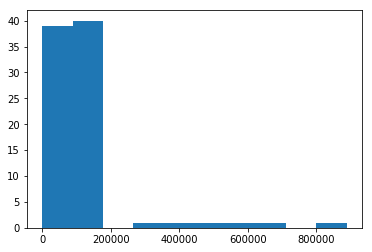

In [22]:
# Investigate patterns in the amount of missing data in each column.
col_missing_values = azdias_clean.isna().sum(axis=0)
plt.hist(col_missing_values);

Summary: the majority of columns seem to have less than 200000 missing values. 

In [23]:
col_del = col_missing_prop_sorted['features'][:6]
col_del

40        TITEL_KZ
0         AGER_TYP
47    KK_KUNDENTYP
64    KBA05_BAUMAX
11     GEBURTSJAHR
43        ALTER_HH
Name: features, dtype: object

In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)
azdias_fin = azdias_clean.drop(columns=col_del)

In [25]:
azdias_fin.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The analysis of missing values revealed that we have 6 columns with missing values for more than 200000 rows or in other words more than 30% of data in these columns is missing. These columns are: 
- TITEL_KZ
- AGER_TYP
- KK_KUNDENTYP
- KBA05_BAUMAX
- GEBURTSJAHR
- ALTER_HH 
<br><br>
Because of large amount of missing values, we cannot use imputation methods (or it will eventually skew the results) for these columns and hence it was decided to remove them from further analysis completely. 

#### Step 1.1.3: Assess Missing Data in Each Row

NOTE: I decided to look at missing values in each row on the dataset resulting from the previous step (not the original one) - i.e. the one with deleted 6 columns. I find that in this way I could retain more rows - e.g. when dividing into a subset with below 5 missing values in a row I get 719624 rows on the dataset with 79 columns vs. 599243 rows in the original dataset with 85 columns.

In [26]:
# How much data is missing in each row of the dataset?
row_missing_prop = pd.DataFrame(azdias_fin.isna().mean(axis=1)).reset_index()
row_missing_prop.columns = ['rows_num', 'missing_prop']
row_missing_prop_sorted = row_missing_prop.sort_values(by=['missing_prop'], ascending=False)
row_missing_prop_sorted.head(10)

,rows_num,missing_prop
732775,732775,0.620253
643174,643174,0.620253
472919,472919,0.607595
345274,345274,0.594937
299868,299868,0.594937
582092,582092,0.594937
681255,681255,0.594937
818343,818343,0.594937
582109,582109,0.594937
439981,439981,0.594937


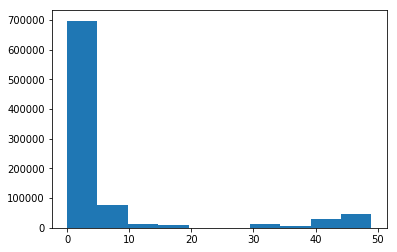

In [27]:
row_missing_values = azdias_fin.isna().sum(axis=1)
plt.hist(row_missing_values);

**Summary**: based on the histogram, it seems like there are two different patterns for row missing values. About 800000 or something like 90% of rows have missing values in less than 20 columns, while the rest has much more  missing values - in more than 20 columns.

In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
subset_less_missing = azdias_fin[row_missing_values <= 20]
subset_more_missing = azdias_fin[row_missing_values > 20]

print("subset_less_missing shape:", subset_less_missing.shape)
print("subset_more_missing shape:", subset_more_missing.shape)
print("prop of missing values in subset_less_missing relative to all datapoints: {:.2f}%".format(100*subset_less_missing.isna().sum().sum()/subset_less_missing.size))
print("prop of missing values in subset_less_missing relative to all datapoints: {:.2f}%".format(100*subset_more_missing.isna().sum().sum()/subset_less_missing.size))

subset_less_missing shape: (797426, 79)
subset_more_missing shape: (93795, 79)
prop of missing values in subset_less_missing relative to all datapoints: 1.59%
prop of missing values in subset_less_missing relative to all datapoints: 6.41%


In [29]:
# let's create a list of top 20 columns that has the least of missing values (aka non-missing features)
col_nomissing = azdias_clean.isna().sum(axis=0).sort_values(ascending=True).head(20).index
col_nomissing

Index(['ZABEOTYP', 'SEMIO_TRADV', 'SEMIO_PFLICHT', 'SEMIO_KAEM', 'SEMIO_DOM',
       'SEMIO_KRIT', 'SEMIO_RAT', 'SEMIO_KULT', 'SEMIO_ERL', 'SEMIO_LUST',
       'SEMIO_VERT', 'SEMIO_MAT', 'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_FAM',
       'FINANZ_VORSORGER', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_ANLEGER'],
      dtype='object')

In [30]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot_subset_countplot_by_column(col):
    base_color = sns.color_palette()[0]
    plt.figure(figsize=(6, 2))
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1,2,1)
    plt.hist(data = subset_more_missing, x = col, color = base_color);
    #plt.hist(subset_more_missing[col])
    plt.xlabel(col)
    plt.title('subset_more_missing')
    
    plt.subplot(1,2,2)
    plt.hist(data = subset_less_missing, x = col, color = base_color);
    #plt.hist(subset_less_missing[col])
    plt.xlabel(col)
    plt.title('subset_less_missing')

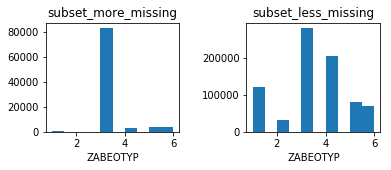

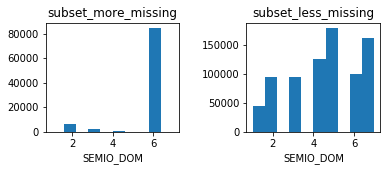

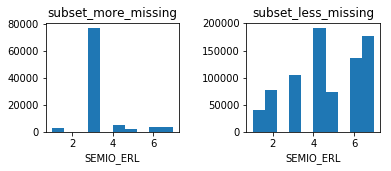

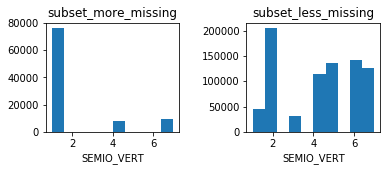

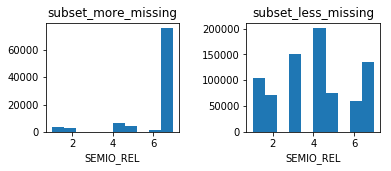

In [31]:
# change the values of col_nomissing[i] between 0 and 19  
# to see the quality of distributions for these columns for the two subsets 
plot_subset_countplot_by_column(col_nomissing[0]);
plot_subset_countplot_by_column(col_nomissing[4]);
plot_subset_countplot_by_column(col_nomissing[8]);
plot_subset_countplot_by_column(col_nomissing[10]);
plot_subset_countplot_by_column(col_nomissing[12]);

In [32]:
azdias_fin = subset_less_missing

#checking the size of the new dataset without 6 columns
print("number of columns:", azdias_fin.shape[1])
print("number of rows in the original dataset:", azdias.shape[0])
print("number of rows in the final dataset:", azdias_fin.shape[0])
print("prop of final dataset with no missing data: {0:.2f}%".format(100*azdias_fin.shape[0]/azdias.shape[0]))

number of columns: 79
number of rows in the original dataset: 891221
number of rows in the final dataset: 797426
prop of final dataset with no missing data: 89.48%


### Step 1.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [33]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, I need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_col = feat_info[feat_info['type'] == 'categorical'].attribute.reset_index()
categorical_col

,index,attribute
0,0,AGER_TYP
1,2,ANREDE_KZ
2,3,CJT_GESAMTTYP
3,10,FINANZTYP
4,12,GFK_URLAUBERTYP
5,13,GREEN_AVANTGARDE
6,17,LP_FAMILIE_FEIN
7,18,LP_FAMILIE_GROB
8,19,LP_STATUS_FEIN
9,20,LP_STATUS_GROB


In [35]:
categorical_col['unique'] = [azdias_clean[categorical_col['attribute'][i]].unique() for i in range(categorical_col.shape[0])]

In [36]:
categorical_col['num_categories'] = [len(azdias_clean[categorical_col['attribute'][i]].unique()) for i in range(categorical_col.shape[0])]

In [37]:
categorical_col

,index,attribute,unique,num_categories
0,0,AGER_TYP,"[nan, 2.0, 3.0, 1.0]",4
1,2,ANREDE_KZ,"[1.0, 2.0]",2
2,3,CJT_GESAMTTYP,"[2.0, 5.0, 3.0, 4.0, 1.0, 6.0, nan]",7
3,10,FINANZTYP,"[4.0, 1.0, 6.0, 5.0, 2.0, 3.0]",6
4,12,GFK_URLAUBERTYP,"[10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4....",13
5,13,GREEN_AVANTGARDE,"[0.0, 1.0]",2
6,17,LP_FAMILIE_FEIN,"[2.0, 5.0, 1.0, nan, 10.0, 7.0, 11.0, 3.0, 8.0...",12
7,18,LP_FAMILIE_GROB,"[2.0, 3.0, 1.0, nan, 5.0, 4.0]",6
8,19,LP_STATUS_FEIN,"[1.0, 2.0, 3.0, 9.0, 4.0, 10.0, 5.0, 8.0, 6.0,...",11
9,20,LP_STATUS_GROB,"[1.0, 2.0, 4.0, 5.0, 3.0, nan]",6


In [38]:
# because we have NaNs, those binary categorical values don't need to be reencoded that have 3 unique values
categorical_col[categorical_col['num_categories'] == 3]

,index,attribute,unique,num_categories
12,39,SOHO_KZ,"[nan, 1.0, 0.0]",3
14,41,VERS_TYP,"[nan, 2.0, 1.0]",3
18,55,OST_WEST_KZ,"[nan, W, O]",3


In [39]:
# let's deal first with 'OST_WEST_KZ'
azdias_fin = pd.get_dummies(data = azdias_fin, columns = ['OST_WEST_KZ'], drop_first=True)

In [40]:
# choosing multi-categorical features and dropping OST_WEST_KZ column because it was reencoded separately
cat_var_reencode = categorical_col[(categorical_col['num_categories'] > 3)].attribute
cat_var_reencode

0             AGER_TYP
2        CJT_GESAMTTYP
3            FINANZTYP
4      GFK_URLAUBERTYP
6      LP_FAMILIE_FEIN
7      LP_FAMILIE_GROB
8       LP_STATUS_FEIN
9       LP_STATUS_GROB
10    NATIONALITAET_KZ
11         SHOPPER_TYP
13            TITEL_KZ
15            ZABEOTYP
16        KK_KUNDENTYP
17         GEBAEUDETYP
19     CAMEO_DEUG_2015
20      CAMEO_DEU_2015
Name: attribute, dtype: object

In [41]:
# the last feature 'CAMEO_DEU_2015' has 45 values to reencode, will be dropped here:
cat_var_reencode = cat_var_reencode[:-1]
cat_var_reencode

0             AGER_TYP
2        CJT_GESAMTTYP
3            FINANZTYP
4      GFK_URLAUBERTYP
6      LP_FAMILIE_FEIN
7      LP_FAMILIE_GROB
8       LP_STATUS_FEIN
9       LP_STATUS_GROB
10    NATIONALITAET_KZ
11         SHOPPER_TYP
13            TITEL_KZ
15            ZABEOTYP
16        KK_KUNDENTYP
17         GEBAEUDETYP
19     CAMEO_DEUG_2015
Name: attribute, dtype: object

In [42]:
# since all features with 'GROB' are aggregations of the equivalent 'FEIN' features, we can drop 'FEIN'
cat_var_reencode = cat_var_reencode.drop(labels=[6, 8])
cat_var_reencode

0             AGER_TYP
2        CJT_GESAMTTYP
3            FINANZTYP
4      GFK_URLAUBERTYP
7      LP_FAMILIE_GROB
9       LP_STATUS_GROB
10    NATIONALITAET_KZ
11         SHOPPER_TYP
13            TITEL_KZ
15            ZABEOTYP
16        KK_KUNDENTYP
17         GEBAEUDETYP
19     CAMEO_DEUG_2015
Name: attribute, dtype: object

In [43]:
#updating azdias_fin
azdias_fin = azdias_fin.drop('CAMEO_DEU_2015', axis=1)

In [44]:
# updating azdias_fin
col_fein = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
azdias_fin = azdias_fin.drop(col_fein, axis=1)

In [45]:
# now we need to filter columns that are in the final azdias dataset (because we removed some columns from the analysis when handling missing data)
cat_var_reencode_fin = azdias_fin.columns[azdias_fin.columns.isin(cat_var_reencode)].tolist()

In [46]:
print(cat_var_reencode_fin)
print(len(cat_var_reencode_fin))

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
10


In [47]:
azdias_fin = pd.get_dummies(data = azdias_fin, columns = cat_var_reencode_fin)

In [48]:
#checking new number of columns after reencoding 
len(azdias_fin.columns)

129

In [49]:
#checking new features that were added after reencoding. Should start from new version of 'OST_WEST_KZ'
azdias_fin.columns[65:]

Index(['OST_WEST_KZ_W', 'CJT_GESAMTTYP_1.0', 'CJT_GESAMTTYP_2.0',
       'CJT_GESAMTTYP_3.0', 'CJT_GESAMTTYP_4.0', 'CJT_GESAMTTYP_5.0',
       'CJT_GESAMTTYP_6.0', 'FINANZTYP_1.0', 'FINANZTYP_2.0', 'FINANZTYP_3.0',
       'FINANZTYP_4.0', 'FINANZTYP_5.0', 'FINANZTYP_6.0',
       'GFK_URLAUBERTYP_1.0', 'GFK_URLAUBERTYP_2.0', 'GFK_URLAUBERTYP_3.0',
       'GFK_URLAUBERTYP_4.0', 'GFK_URLAUBERTYP_5.0', 'GFK_URLAUBERTYP_6.0',
       'GFK_URLAUBERTYP_7.0', 'GFK_URLAUBERTYP_8.0', 'GFK_URLAUBERTYP_9.0',
       'GFK_URLAUBERTYP_10.0', 'GFK_URLAUBERTYP_11.0', 'GFK_URLAUBERTYP_12.0',
       'LP_FAMILIE_GROB_1.0', 'LP_FAMILIE_GROB_2.0', 'LP_FAMILIE_GROB_3.0',
       'LP_FAMILIE_GROB_4.0', 'LP_FAMILIE_GROB_5.0', 'LP_STATUS_GROB_1.0',
       'LP_STATUS_GROB_2.0', 'LP_STATUS_GROB_3.0', 'LP_STATUS_GROB_4.0',
       'LP_STATUS_GROB_5.0', 'NATIONALITAET_KZ_1.0', 'NATIONALITAET_KZ_2.0',
       'NATIONALITAET_KZ_3.0', 'SHOPPER_TYP_0.0', 'SHOPPER_TYP_1.0',
       'SHOPPER_TYP_2.0', 'SHOPPER_TYP_3.0', 'ZABE

**Commentary**: we reencoded 11 columns and dropped 3 new columns (in addition to 6 done previously). The resulting dataset has 129 columns. So this means that we have (85-11-3-6)=65 old columns. The rest 64 are our new binary reencoded features starting from OST_WEST_KZ_W.

#### Discussion 1.2.1: Re-Encode Categorical Features

There are 21 categorical features in the dataset.
Among these, we have 4 features with binary categories - ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ and VERS_TYP. These can be left unchanged.
One binary variable that takes on non-numeric values - OST_WEST_KZ - needs to be reencoded with dummy variable.
All other categorical features need to be reencoded/dropped. So here's my approach:

I first reencoded 'OST_WEST_KZ' with get_dummies, dropping the first column.

I dropped 'CAMEO_DEU_2015' because it has too many values. 

I also excluded from the list of categorical features (ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ and VERS_TYP) because they are binary and don't need to be reencoded. 

Then I dropped features LP_FAMILIE_FEIN and LP_STATUS_FEIN because they are highly correlated with LP_FAMILIE_GROB and LP_STATUS_GROB (which are basically aggregates of 'FEIN' features). <br>

Finally, I checked what other categorical variables were dropped in the previous step when looking for missing values. It turned out that 3 columns were already removed (AGER_TYP, TITEL_KZ, KK_KUNDENTYP)

After all, from 21 categorical features only 10 were left.

*Reencoding*: I applied onehotencoding on 10 features that were left from the previous step. This created 64 binary vectors. Together with reencoded earlier OST_WEST_KZ, this means we added 64 new features that are dummies for their earlier versions.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [50]:
#checking which columns where defined as 'mixed'
mixed_col = feat_info[feat_info['type'] == 'mixed'].attribute.reset_index()
mixed_col['num_categories'] = [len(azdias[mixed_col['attribute'][i]].unique()) for i in range(mixed_col.shape[0])]
mixed_col

,index,attribute,num_categories
0,15,LP_LEBENSPHASE_FEIN,42
1,16,LP_LEBENSPHASE_GROB,14
2,22,PRAEGENDE_JUGENDJAHRE,16
3,56,WOHNLAGE,9
4,59,CAMEO_INTL_2015,23
5,64,KBA05_BAUMAX,7
6,79,PLZ8_BAUMAX,6


**Summary**: there are 7 features marked as 'mixed' in the original dataset. 'KBA05_BAUMAX' was already removed from the dataset due to the missing values.LP_LEBENSPHASE_FEIN is basically the same as LP_LEBENSPHASE_GROB and will be dropped. Let's check if LP_LEBENSPHASE_GROB is highly correlated with categorical features 'LP_FAMILIE_FEIN'/'LP_STATUS_FEIN' that we already reencoded:


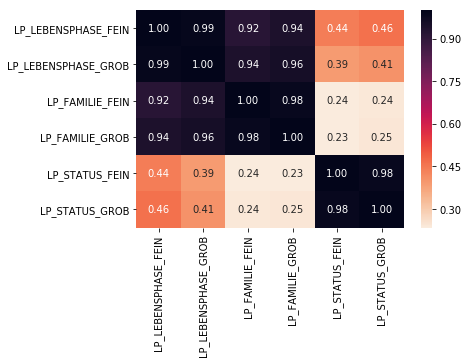

In [51]:
lp_col = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB']
sns.heatmap(azdias[lp_col].corr(), cmap = 'rocket_r', annot = True, fmt = '.2f');

Summary: LP_LEBENSPHASE_GROB is highly correlated with categorical feature 'LP_FAMILIE_FEIN' and so can be also dropped from further analysis.

In [52]:
azdias_fin = azdias_fin.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1)

So, in the following we can concentrate on 4 'mixed' features - PRAEGENDE_JUGENDJAHRE, WOHNLAGE,  CAMEO_INTL_2015, PLZ8_BAUMAX. 

**Dealing with PRAEGENDE_JUGENDJAHRE**

In [53]:
# from readme file we know that 
# values in the list [1,3,5,8,10,12,14] correspond to 'mainstream', will be encoded with 1
# values in the list [2,4,6,7,9,11,13,15] correspond to 'avantgarde', will be encoded with 0

azdias_fin['movement'] = azdias_fin['PRAEGENDE_JUGENDJAHRE'].replace([1,3,5,8,10,12,14], 1).replace([2,4,6,7,9,11,13,15], 0)

In [54]:
azdias_fin['movement'].head(10)

1     1.0
2     0.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     0.0
9     0.0
10    1.0
Name: movement, dtype: float64

In [55]:
#checking if the newly engineered feature 'mainstream' is correlated with feature 'GREEN_AVANTGARDE'
(azdias_fin['GREEN_AVANTGARDE'].astype(int)).corr(azdias_fin['movement'])

-0.9999999999999999

In [56]:
azdias_fin = azdias_fin.drop('movement', axis=1)

Commentary: since we have already the feature 'GREEN_AVANTGARDE' in our dataset, there is no need to create a new feature 'mainstream' that is the opposite of 'GREEN_AVANTGARDE. Hence, it will be dropped.

In [57]:
# from readme file we can construct codes as dict 
codes = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
azdias_fin['decade'] = azdias_fin['PRAEGENDE_JUGENDJAHRE'].replace(codes)

In [58]:
azdias_fin['decade'].head()

1    90.0
2    90.0
3    70.0
4    70.0
5    50.0
Name: decade, dtype: float64

In [59]:
#we are done reengineering 'PRAEGENDE_JUGENDJAHRE' and can now drop it from further analysis
azdias_fin = azdias_fin.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

**Dealing with CAMEO_INTL_2015**:

In [60]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.    
azdias_fin['life_stage'] = azdias_fin['CAMEO_INTL_2015'].astype(float)%10
azdias_fin['life_stage'].head()

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: life_stage, dtype: float64

In [61]:
azdias_fin['wealth'] = (azdias_fin['CAMEO_INTL_2015'].astype(float)/10)-azdias_fin['CAMEO_INTL_2015'].astype(float)%10/10
azdias_fin['wealth'].head()

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: wealth, dtype: float64

In [62]:
#we are done reengineering 'CAMEO_INTL_2015' and can now drop it from further analysis
azdias_fin = azdias_fin.drop('CAMEO_INTL_2015', axis=1)

**Dealing with WOHNLAGE**:

Feature 'WOHNLAGE' is constructed from two different variables - one based on quality of the neighborhood and another one is flag for rural neighborhood (values 7 and 8). We cannot disaggregate info on quality of neigborhood. So this info will be gone (alternative - create dummy var on WOHNLAGE, but we have some information quality of neighborhood at the region level, so I decided not to create a dummy). <br>
Let's create a new feature solely as flag for rural neighborhood:

In [63]:
azdias_fin['rural'] = azdias_fin['WOHNLAGE'].replace([1,2,3,4,5], 0).replace([7,8], 1)
azdias_fin['rural'].head()

1    0.0
2    0.0
3    1.0
4    0.0
5    1.0
Name: rural, dtype: float64

In [64]:
#we are done reengineering 'WOHNLAGE' and can now drop it from further analysis
azdias_fin = azdias_fin.drop('WOHNLAGE', axis=1)

**Dealing with PLZ8_BAUMAX**:

Feature PLZ8_BAUMAX is constructed from variables that refer to either family homes or business buildings. Since we have the information on family homes in other features (PLZ8_ANTG1 through PLZ8_ANTG4) we can ignore this information in PLZ8_BAUMAX and create a new feature that would only flag business buildings:

In [65]:
azdias_fin['business_building'] = azdias_fin['PLZ8_BAUMAX'].replace([1,2,3,4], 0).replace(5, 1)
azdias_fin['business_building'].head()

1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: business_building, dtype: float64

In [66]:
#we are done reengineering 'PLZ8_BAUMAX' and can now drop it from further analysis
azdias_fin = azdias_fin.drop('PLZ8_BAUMAX', axis=1)

In [67]:
#checking how many features left after this step
azdias_fin.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6', 'CAMEO_DEUG_2015_7',
       'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9', 'decade', 'life_stage',
       'wealth', 'rural', 'business_building'],
      dtype='object', length=128)

**Commentary**: from the previous step, I have 129 features. In this step, I dropped 2 features ('LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB') and engineered 5 new features from 4 features that were then dropped (PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015, WOHNLAGE, PLZ8_BAUMAX). So at the end we have 129-2+5-4=128 features.

#### Discussion 1.2.2: Engineer Mixed-Type Features

There are 7 features marked as 'mixed' in the dataset. 

1. 'LP_LEBENSPHASE_FEIN': I decided to drop it because it has to many categories (41) and we haves similar feature 'LP_LEBENSPHASE_GROB' which presents aggregated data. 


2. 'LP_LEBENSPHASE_GROB':  it turned out that 'LP_LEBENSPHASE_GROB' is highly correlated with the categorical variable 'LP_FAMILIE_FEIN' so that I decided to drop it too.


3. 'PRAEGENDE_JUGENDJAHRE': Based on 'PRAEGENDE_JUGENDJAHRE' we created two new features - 'mainstream' which is a binary variable for movement and 'decade' which is interval-type variable for a decade.  However, the newly engineered feature 'mainstream' is fully negatively correlated with another feature in our dataset 'GREEN_AVANTGARDE'. So there is no need to duplicate this information. The feature 'mainstream' will be excluded. 


4. 'CAMEO_INTL_2015': Based on 'CAMEO_INTL_2015' we created two new ordinal features 'wealth' and 'life_stage' which do not need being reencoded. 


5. 'KBA05_BAUMAX': this feature was already dropped in earlier stages when discovered that it has lots of missing values


6. 'WOHNLAGE': I created a new feature 'rural' that is dummy for rural neighborhood


7. 'PLZ8_BAUMAX': I created new feature 'business_building' that is dummy for business building 

#### Step 1.2.3: Complete Feature Selection

The data frame should only have the columns that I want to keep. To summarize, it should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [68]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_fin.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6', 'CAMEO_DEUG_2015_7',
       'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9', 'decade', 'life_stage',
       'wealth', 'rural', 'business_building'],
      dtype='object', length=128)

In [69]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_fin.shape

(797426, 128)

## NOTE:
#### I've integrated this step in steps 1.2.1. and 1.2.2. I found it easier to follow transformations while they occur. My final data frame azdias_fin contains only the features I want to keep for further analysis.

### Step 1.3: Create a Cleaning Function

In [70]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    print("Start step 1: dealing with missing values")
    df = df.replace({'X': np.nan, 'XX': np.nan})
    feat_info['missing_transform'] = feat_info['missing_or_unknown'].apply(lambda x: '[-1]' if x in ['[-1,X]', '[XX]', '[-1,XX]'] else x)
    feat_info['missing_transform'] = [eval(feat_info['missing_transform'][i]) for i in feat_info['missing_transform'].index]

    for i, col in enumerate(feat_info['attribute']):
        df.loc[df[col].isin(feat_info['missing_transform'][i]), col] = np.nan 
    print("Checking number of missing values after step 1:", df.isna().sum().sum())
    print("")
        
    # remove selected columns and rows, ...
    print("Start step 2: removing selected columns and rows")
    col_del = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH',
               'LP_LEBENSPHASE_FEIN','LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015', 'LP_LEBENSPHASE_GROB']

    df = df.drop(df[col_del], axis=1)
    row_missing_values = df.isna().sum(axis=1)
    df = df[row_missing_values <= 20]   
    print("Checking the new shape of the data frame after step 2:", df.shape)
    print("")
    
    # select, re-encode, and engineer column values.
    print("Start step 3.1: reencoding with dummies") 
    cat_var_reencode = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB',
                        'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
                        'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
    
    df = pd.get_dummies(data = df, columns = cat_var_reencode)    
    df = pd.get_dummies(data = df, columns = ['OST_WEST_KZ'], drop_first=True)   
    
    print("Start step 3.2: reengineering features")
    codes = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE'].replace(codes)
    df['life_stage'] = df['CAMEO_INTL_2015'].astype(float)%10
    df['wealth'] = (df['CAMEO_INTL_2015'].astype(float)/10)-df['CAMEO_INTL_2015'].astype(float)%10/10
    df['rural'] = df['WOHNLAGE'].replace([1,2,3,4,5], 0).replace([7,8], 1)
    df['business_building'] = df['PLZ8_BAUMAX'].replace([1,2,3,4], 0).replace(5, 1)
    
    col_reengineered = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE', 'PLZ8_BAUMAX']
    df = df.drop(df[col_reengineered], axis=1)
    print("Checking the new shape of the data frame after step 3:", df.shape)
    print("Checking the number of missing values in the resulting data frame:", df.isna().sum().sum())
        
    # Return the cleaned dataframe.
    return df.reset_index(drop=True)

In [71]:
azdias_features = clean_data(azdias)

Start step 1: dealing with missing values
Checking number of missing values after step 1: 8373929

Start step 2: removing selected columns and rows
Checking the new shape of the data frame after step 2: (797754, 74)

Start step 3.1: reencoding with dummies
Start step 3.2: reengineering features
Checking the new shape of the data frame after step 3: (797754, 128)
Checking the number of missing values in the resulting data frame: 751844


**Commentary**: The number of missing values after step 1 is the same as when the step was performed without function call. The number of features after transformation via function is also the same. However, we retained more rows in the cleaned via function dataset compared to what we did earlier step by step (797754 vs 797426). The reason is  because in the clean_data function I have clumped together all 11 columns I decided to delete before removing rows with missing values in step 2. While earlier, I removed only 6 of them at first and the decision to remove the remaining 5 came later. <br>



## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [72]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer(strategy='most_frequent')
azdias_features_imputed = imputer.fit_transform(azdias_features)

azdias_features_imputed = pd.DataFrame(azdias_features_imputed, columns=azdias_features.columns)
azdias_features_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,OST_WEST_KZ_W,decade,life_stage,wealth,rural,business_building
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,1.0,0.0,1.0,90.0,1.0,5.0,0.0,0.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,90.0,4.0,2.0,0.0,0.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,70.0,2.0,1.0,1.0,0.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,0.0,0.0,0.0,1.0,70.0,3.0,4.0,0.0,0.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,1.0,0.0,1.0,50.0,4.0,5.0,1.0,0.0


**Commentary**: since many columns in this dataset are ordinal, I decided to impute the most frequent values. 

In [73]:
#checking if the result of imputation
azdias_features_imputed.isna().sum().sum()

0

In [74]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler().fit(azdias_features_imputed) 
azdias_features_scaled = scaler.transform(azdias_features_imputed)

In [75]:
#checking if scaler performed well on 10 first features
azdias_features_scaled.mean(axis=0)[:10]

array([ 8.03392459e-18, -6.37013622e-17,  4.62618673e-17,  1.12047418e-16,
       -7.59036645e-17, -3.71591279e-17, -1.53953865e-16, -1.20669191e-16,
        1.39373450e-16, -2.91799801e-16])

In [76]:
#checking if scaler performed well on 10 first features
azdias_features_scaled.std(axis=0)[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

**Commentary**: scaler works as expected - all features were transformed correctly and have mean 0 and std 1.

### Discussion 2.1: Apply Feature Scaling

Since I have decided to remove data with missing points earlier in this project, I didn't have to clean the dataset any further. 
The decision to remove these points was driven by another decision - namely to reencode 12 categorical featuers with their dummies. If I kept missing values at that stage, I could have ended up with additional 12 columns for NaNs. <br>
Alternatively, if I decided to delete the 12 categorical features all together, I could have kept the certain level of missing data in rows (say up to 5) and later impute these values.

### Step 2.2: Perform Dimensionality Reduction

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [77]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(azdias_features_scaled)

In [78]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

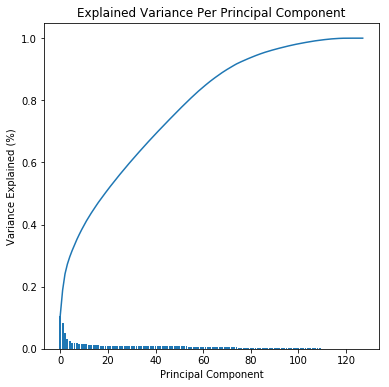

In [79]:
scree_plot(pca)

In [80]:
# how many components together explain about 80% of variance?
cum_expl_var_ratio = np.cumsum(pca.explained_variance_ratio_)
len(cum_expl_var_ratio[cum_expl_var_ratio <= 0.805])

55

In [81]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(55).fit(azdias_features_scaled)
azdias_features_pca = pca.transform(azdias_features_scaled)

In [82]:
np.cumsum(pca.explained_variance_ratio_)

array([0.1068349 , 0.18904279, 0.24116579, 0.27267736, 0.29625962,
       0.31635506, 0.33476651, 0.35233056, 0.36839587, 0.38360877,
       0.39790406, 0.41175416, 0.42452159, 0.43675519, 0.44847467,
       0.45984398, 0.47116332, 0.48177354, 0.49211878, 0.50240449,
       0.51260587, 0.52251093, 0.53222582, 0.54189901, 0.55148549,
       0.56084479, 0.5701031 , 0.57918112, 0.58823775, 0.59722533,
       0.60604118, 0.61484042, 0.62356428, 0.63221521, 0.64078305,
       0.6493133 , 0.65777359, 0.66607647, 0.67434415, 0.68247155,
       0.69058794, 0.69861201, 0.70659242, 0.71456863, 0.72244326,
       0.73029756, 0.73810932, 0.74590137, 0.75366262, 0.76133828,
       0.76897082, 0.77650509, 0.78401029, 0.79134442, 0.79849783])

### Discussion 2.2: Perform Dimensionality Reduction

As a rule of thumb, one should keep as many components that together they would explain about 80% of variance. From the scree plot we can conclude that about 55 components explain 80% of variance. So I decided to keep 55 PCA components for the clustering part of the project. <br>
Moreover, the first three components add the most to the explanation of the variance (together explain about 25%), while the rest of the components' weights are rather small (~1-2%). 

### Step 2.3: Interpret Principal Components

Let's check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- Investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [83]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_pca(i, df_scaled):
    weights = pd.DataFrame(pca.components_[i-1], columns=["PCA_"+str(i)], index = df_scaled.columns)
    weights = weights.sort_values(by=["PCA_"+str(i)])
    print("positive top5 weights:\n", weights.tail(5))
    print("\n-----------------------------\n")
    print("negative top5 weights:\n", weights.head(5))

In [84]:
map_pca(1, azdias_features)

positive top5 weights:
                        PCA_1
HH_EINKOMMEN_SCORE  0.181879
wealth              0.182751
PLZ8_ANTG4          0.186437
PLZ8_ANTG3          0.192128
LP_STATUS_GROB_1.0  0.198213

-----------------------------

negative top5 weights:
                       PCA_1
FINANZ_MINIMALIST -0.204375
MOBI_REGIO        -0.193761
PLZ8_ANTG1        -0.192182
KBA05_GBZ         -0.186407
KBA05_ANTG1       -0.184530


In [85]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_pca(2, azdias_features)

positive top5 weights:
                          PCA_2
SEMIO_LUST            0.161946
SEMIO_ERL             0.187227
ZABEOTYP_3.0          0.203869
FINANZ_VORSORGER      0.214276
ALTERSKATEGORIE_GROB  0.229072

-----------------------------

negative top5 weights:
                           PCA_2
decade                -0.224657
FINANZ_SPARER         -0.216684
SEMIO_REL             -0.216012
FINANZ_UNAUFFAELLIGER -0.212395
SEMIO_TRADV           -0.206713


In [86]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_pca(3, azdias_features)

positive top5 weights:
                   PCA_3
FINANZTYP_5.0  0.136707
SEMIO_KULT     0.248099
SEMIO_SOZ      0.257945
SEMIO_FAM      0.258574
SEMIO_VERT     0.327127

-----------------------------

negative top5 weights:
                PCA_3
ANREDE_KZ  -0.353231
SEMIO_KAEM -0.325678
SEMIO_DOM  -0.297417
SEMIO_KRIT -0.271625
SEMIO_ERL  -0.199927


### Discussion 2.3: Interpret Principal Components

1. **PCA_1 can be called "low income earners segment"**: <br>
The first principal component PCA_1 has the following top5 features with the highest/lowest weights:

*negative weights*:
MOBI_REGIO, FINANZ_MINIMALIST, KBA05_ANTG1, PLZ8_ANTG1, KBA05_GBZ <br>

*positive weights*: HH_EINKOMMEN_SCORE, wealth, PLZ8_ANTG4, PLZ8_ANTG3, LP_STATUS_GROB_1.0 <br>

The PCA_1 is mainly about financial wealth and the number of buildings in the region/microcell where the person lives. Thus, positive weights here point out to 'low-income earners', 'poor households', 'very low income' and to region with 'high share of 6 or 10+ family homes' (which is logical given that poorer families tend to live in the densely populated areas which are usually cheaper). The negative weights are associated with such features as mobility, low financial interest, share of 1-2 family homes. From the way that these features are constructed, we can say that the relationship between the negatively weighted features and positively weighted features are as follows:
the more low-income earners, the higher the share of 6 or 10+ family homes in the microcell, poorer households and more low income families is associated with higher mobility, higher 'low financial interest', lower share of 1-2 family homes. 

2. **PCA_2 can be called "conservative seniors segment"**: <br>
The second principal component PCA_2 has the following top5 features with the highest/lowest weights:

*negative weights*: decade, SEMIO_REL, FINANZ_SPARER, FINANZ_UNAUFFAELLIGER, SEMIO_TRADV <br>

*positive weights*: SEMIO_LUST, SEMIO_ERL, ZABEOTYP_3.0, FINANZ_VORSORGER, ALTERSKATEGORIE_GROB

The PCA_2 revolves around such topics as money saving, conservatism/religiosity, old age. Thus, positive weights point out to the fact that the persons in this segment are the least 'sensual-minded', 'low event-oriented', believe their energy is ‘fair supplied’, they also have low financial provisions/savings and are seniors (>50 years). When considering the negatively weighted features and their relationship with the positively weighted features we get fuller picture of the individuals in this segment. In addition to the said above, they are born in earlier decade (probably 1940s/50s ), they have the highest affinity to religion, they are financially modest, more active money-savers and are the most tradional-minded. 

3. **PCA_3 can be called "practical male segment"**: <br>
The third principal component PCA_3 has the following top5 features with the highest/lowest weights:

*negative weights*: ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_ERL <br>

*positive weights*: FINANZ_MINIMALIST, SEMIO_KULT, SEMIO_FAM, SEMIO_SOZ, SEMIO_VERT

The PCA_3 creates a distinctive segment consiting of mostly male that are self-confident, less family oriented and mostly event-oriented. So, the positively weighted components are associated here with such characteristics as 'the least dreamful', 'the least socially-minded', 'the least family-minded', 'the least cultural-minded', the least 'low financially interested'. While negatively weighted components correspond to features such as 'male', highly ‘combative attitude’,  'very dominant-minded', 'the most critical-minded', 'the most event-oriented'. 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [87]:
# Over a number of different cluster counts...
range_n_clusters = [5, 10, 15, 20, 25]
sum_of_squared_distances = []
since = time.time()

with active_session():
    for n_clusters in range_n_clusters:
        cluster_start = time.time()
        print("calculating {} clusters".format(n_clusters))
        # run k-means clustering on the data and...
        clusterer = KMeans(n_clusters=n_clusters, random_state=120).fit(azdias_features_scaled)

        # compute the average within-cluster distances.
        sum_of_squared_distances.append(clusterer.inertia_)
        print("sum of squared distances:", clusterer.inertia_)
        print("time for this cluster:", time.time() - cluster_start)

time_elapsed = time.time() - since
print('Clustering complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

calculating 5 clusters
sum of squared distances: 85420965.92336746
time for this cluster: 215.34582018852234
calculating 10 clusters
sum of squared distances: 80123262.11216384
time for this cluster: 428.9132068157196
calculating 15 clusters
sum of squared distances: 77357465.88423884
time for this cluster: 837.2431218624115
calculating 20 clusters
sum of squared distances: 75472896.78918467
time for this cluster: 999.5252838134766
calculating 25 clusters
sum of squared distances: 72981948.56508066
time for this cluster: 1267.9483151435852
Clustering complete in 62m 30s


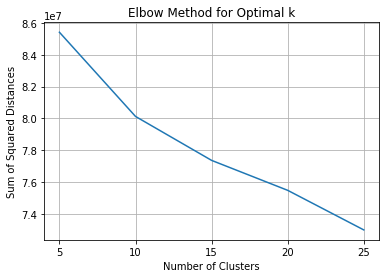

In [88]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range_n_clusters, sum_of_squared_distances)
plt.xlabel('Number of Clusters')
plt.xticks(range_n_clusters, range_n_clusters)
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.grid();

In [89]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
clusterer = KMeans(n_clusters=10, random_state = 123).fit(azdias_features_pca)
azdias_preds = clusterer.predict(azdias_features_pca)

In [90]:
len(azdias_preds)

797754

### Discussion 3.1: Apply Clustering to General Population

 We can see from the plot above that the line has a slight "elbow" at 10 clusters, meaning that each additional cluster reduces the distances between classes much less (marginal gain drops). I also tested some other combinations of cluster numbers earlier. But none gives a nice elbow. So after all I decided to cluster the data into 10 segments.

### Step 3.2: Apply All Steps to the Customer Data

Now that I have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. 

I first load the customers data and apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function I created earlier. 

Then I use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, I don't use a `.fit()` or `.fit_transform()` method to re-fit the old objects. 

Then I carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [91]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [92]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)

Start step 1: dealing with missing values
Checking number of missing values after step 1: 3112918

Start step 2: removing selected columns and rows
Checking the new shape of the data frame after step 2: (141689, 74)

Start step 3.1: reencoding with dummies
Start step 3.2: reengineering features
Checking the new shape of the data frame after step 3: (141689, 127)
Checking the number of missing values in the resulting data frame: 105205


In [93]:
set(azdias_features.columns)-set(customers_clean.columns)

{'GEBAEUDETYP_5.0'}

In [94]:
idx_col = azdias_features.columns.get_loc('GEBAEUDETYP_5.0')
new_col = np.zeros(shape=customers_clean['GEBAEUDETYP_4.0'].shape)

**Commentary**: It turned out that the customers dataset doesn't have values for 'GEBAEUDETYP'=5. So after getting dummies for the categorial variables, we have 127 features in the customers dataset instead of 128 features as in the azdias dataset. That's why I added a new column to customers_clean dataset called 'GEBAEUDETYP_5.0' filled with 0s.

In [95]:
customers_clean.insert(loc=idx_col, column='GEBAEUDETYP_5.0', value=new_col)
customers_clean.shape

(141689, 128)

In [96]:
# checking if GEBAEUDETYP_5.0 was correctly inserted
idx_col == customers_clean.columns.get_loc('GEBAEUDETYP_5.0')

True

In [97]:
customers_clean_imputed = imputer.transform(customers_clean)

customers_scaled = scaler.transform(customers_clean_imputed)  

customers_pca = pca.transform(customers_scaled)

customer_preds = clusterer.predict(customers_pca)

In [98]:
len(customer_preds)

141689

### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In [99]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
customers_preds_prop = round(100*pd.Series(customer_preds).value_counts()/customer_preds.shape[0], 2)
azdias_preds_prop = round(100*pd.Series(azdias_preds).value_counts()/azdias_preds.shape[0], 2)
preds = pd.DataFrame({'customers_count': pd.Series(customer_preds).value_counts(), 
                      'population_count': pd.Series(azdias_preds).value_counts(), 
                      'customers_prop': customers_preds_prop, 'population_prop': azdias_preds_prop})
preds['diff'] = [preds.customers_prop[x]-preds.population_prop[x] for x in preds.index]
preds['overrepresented'] = ['target' if preds['diff'][x] > 1 else '-' for x in preds.index]
preds['underrepresented'] = ['not a target' if preds['diff'][x] < -1 else '-' for x in preds.index]
preds.insert(loc=0, column='cluster', value=preds.index)
preds

,cluster,customers_count,population_count,customers_prop,population_prop,diff,overrepresented,underrepresented
0,0,4695,39139,3.31,4.91,-1.60,-,not a target
1,1,1162,65789,0.82,8.25,-7.43,-,not a target
2,2,14335,85160,10.12,10.67,-0.55,-,-
3,3,2038,83417,1.44,10.46,-9.02,-,not a target
4,4,1486,89844,1.05,11.26,-10.21,-,not a target
5,5,55745,84540,39.34,10.60,28.74,target,-
6,6,14447,100340,10.20,12.58,-2.38,-,not a target
7,7,17705,107107,12.50,13.43,-0.93,-,-
8,8,27395,84016,19.33,10.53,8.80,target,-
9,9,2681,58402,1.89,7.32,-5.43,-,not a target


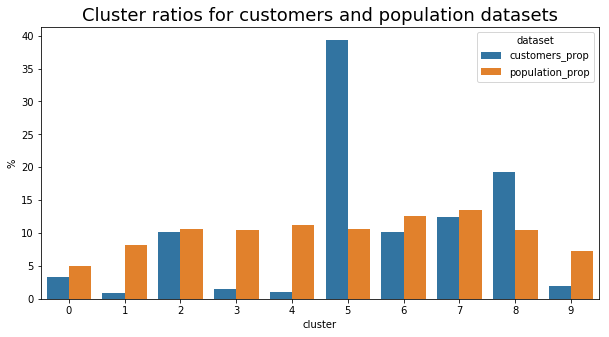

In [100]:
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = pd.melt(preds, id_vars=['cluster'], value_vars=['customers_prop', 'population_prop'], var_name='dataset', value_name='%')
sns.barplot(x='cluster', y='%', hue='dataset', data=tidy);
plt.title('Cluster ratios for customers and population datasets', fontsize=18);

In [101]:
def interpret_clusters(cluster_num):
    pca_inversed = pca.inverse_transform(clusterer.cluster_centers_[cluster_num, :])
    scaler_inversed = np.around(scaler.inverse_transform(pca_inversed), decimals=2)
    results_df = pd.DataFrame(scaler_inversed, azdias_features.columns)
    return results_df

In [102]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
print("target cluster number:", preds['diff'].values.argmax())
target_cluster = interpret_clusters(preds['diff'].values.argmax())
target_cluster

target cluster number: 5


,0
ALTERSKATEGORIE_GROB,3.37
ANREDE_KZ,1.45
FINANZ_MINIMALIST,4.60
FINANZ_SPARER,1.54
FINANZ_VORSORGER,4.33
FINANZ_ANLEGER,1.65
FINANZ_UNAUFFAELLIGER,2.04
FINANZ_HAUSBAUER,2.13
GREEN_AVANTGARDE,0.97
HEALTH_TYP,2.08


In [103]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
print("underrepresented cluster number:", preds['diff'].values.argmin())
underrepres_cluster = interpret_clusters(preds['diff'].values.argmin())
underrepres_cluster

underrepresented cluster number: 4


,0
ALTERSKATEGORIE_GROB,1.79
ANREDE_KZ,1.98
FINANZ_MINIMALIST,1.12
FINANZ_SPARER,4.35
FINANZ_VORSORGER,2.26
FINANZ_ANLEGER,4.18
FINANZ_UNAUFFAELLIGER,3.75
FINANZ_HAUSBAUER,4.21
GREEN_AVANTGARDE,0.02
HEALTH_TYP,2.36


In [104]:
print("exploring the second target cluster:", preds['diff'].sort_values().index[-2])
interpret_clusters(preds['diff'].sort_values().index[-2])

exploring the second target cluster: 8


,0
ALTERSKATEGORIE_GROB,3.28
ANREDE_KZ,1.11
FINANZ_MINIMALIST,4.50
FINANZ_SPARER,1.67
FINANZ_VORSORGER,4.30
FINANZ_ANLEGER,2.20
FINANZ_UNAUFFAELLIGER,1.74
FINANZ_HAUSBAUER,2.29
GREEN_AVANTGARDE,0.05
HEALTH_TYP,2.31


### Discussion 3.3: Compare Customer Data to Demographics Data

The cluster analysis of customer data and democraphics data shows that there are primarily 2 segments of the population that are interested in the company's products. The target audiences for the company are thus clusters 5 and 8, because these segments are overrepresented in the customer data. 

Almost 40% of customers are in Cluster 5, followed by almost 20% in cluster 8. 

TARGET GROUPS: <br>

**Cluster 5 - "conservative prosperous middle-aged green avangarde"**. This segment is comprised of predominantly  prosperous middle-aged Germans (from middle class to upper class) located in West Germany born in the 1960s. They prefer 'green energy' and can be classified as "green avantgarde". These are older families with kids probably already grown-up (but also single/couples). Conservative, likely religious, rational, materialistic and dutiful.

**Cluster 8 - "dominant-minded middle-aged men with average income"**: the second target group consists of mostly dominant-minded and combative men of the same age as the first target group. However, they are less affluent than the first group and belong to established/consumption oriented middleclass with average income. They are unlikely to have kids and live a bit further away from the city center than the first target group.

LEAST LIKELY CUSTOMER GROUP:

**Cluster 4 - "single less affluent women in their 20s-30s"**: The least likely customers are women born in the 1980s that come from working class and are less affluent. They are probably single or are young couples with children. Not religious, dreamful, irrational and not conservative. Price-driven with regards to energy consumption. 
